# This repo contains the following:
- Code for CNN-based classification for MNIST Dataset
- Code for Pointnet classification for MNIST3D Dataset
- Code for Fusion-based classification for MNIST and MNIST3D Dataset

# Load Libraries

In [1]:
# Set-up and load libraries
import os
import glob
import h5py
import numpy as np
import pandas as pd


# Tensorflow and Keras...
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import GlobalMaxPooling1D
from keras.utils import plot_model
from keras.models import Model


# plot and others...
from matplotlib import pyplot as plt
import trimesh
import seaborn as sns
from matplotlib.animation import FuncAnimation
from sklearn.metrics import classification_report
from tqdm import tqdm
# set seed
tf.random.set_seed(1234)

2022-12-05 00:47:14.092097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 00:47:15.799325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-05 00:47:15.799413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-05 00:47:15.799421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Config and parameters

In [2]:
num_cloud_points = 2048
point_cloud_size = (num_cloud_points, 3)
image_size = (30, 30, 1)
num_classes = 10


epochs = 100
batch_size = 32
patience = 2

run_type = 'demo'
# run_type = 'full'

# Load MNIST (2D + 3D) Dataset

In [3]:
# data directory
DATADIR = '../data/multimodal/mnist3d/'

In [4]:
def load_data(data_type, num_pcs):
    '''
    Load train and test data: 2D images, 3D point clouds and labels

    arg:
    data_type: 'train' or 'test'

    return:
    x_2d: 2D images 
    x_3d: 3D pointcloud
    y: labels
    '''
    print(f"Loading {data_type} data......")

    with h5py.File(DATADIR + f'{data_type}_point_clouds.h5', 'r') as points_dataset:

        # Array to store data...
        x_2d = []
        x_3d = []
        y = [] 

        # Looping over the whole dataset..
        for i, (key, sample) in enumerate(points_dataset.items()):
            
            # Saving images...
            x_2d.append(sample['img'][:])

            # Sampling point cloud and saving...
            pointCloud = sample['points'][:]
            num_of_rows = pointCloud.shape[0]
            random_ind = np.random.choice(num_of_rows, size=num_pcs, replace=False)
            pointCloud = pointCloud[random_ind, :]
            x_3d.append(pointCloud)

            # Ssaving labels...
            y.append(sample.attrs['label'])

    # converting to np array...
    x_2d = np.stack(x_2d).reshape(-1, 30, 30, 1)
    x_3d = np.stack(x_3d)
    
    # convert class vectors to binary class matrices
    y = keras.utils.to_categorical(np.array(y), num_classes)  

    # Dropping samples if running as a demo...
    
    # Total samples..............
    total_samples = x_3d.shape[0]
    # Taking random indices for resampling
    random_indices = np.arange(total_samples)
    np.random.shuffle(random_indices)

    # checking the run_type
    if run_type == 'demo':
        print(f"Original shape of 2D samples: {x_2d.shape}")
        print(f"Original shape of 3D samples: {x_3d.shape}")
        demo_samples = 500
        random_indices = random_indices[0:demo_samples]

    # Selecting training and test samples...
    x_2d = x_2d[random_indices]
    x_3d = x_3d[random_indices]
    y = y[random_indices]
   
    # Done loading and processing dataset...
    # print(f"{data_type} data loaded...!")
    print(f"_______________________________________________")
    print(f"Loaded shape of 2D samples: {x_2d.shape}")
    print(f"Loaded shape of 3D samples: {x_3d.shape}")
    print("\n")
    # return image, pointclouds, and labels
    return x_2d, x_3d, y

In [13]:
# Loading training data
x_train_2d, x_train_3d, y_train = load_data(data_type = 'train', num_pcs = num_cloud_points)
y_train_digit = np.argmax(y_train, axis=1) # Convert one-hot to index

# Loading test data
x_test_2d, x_test_3d, y_test = load_data(data_type = 'test', num_pcs = num_cloud_points)
y_test_digit = np.argmax(y_test, axis=1) # Convert one-hot to index
y_test_df = pd.DataFrame(y_test_digit, columns = ['Label'])

x_train_dict = {}
x_train_dict['2D'] = x_train_2d
x_train_dict['3D'] = x_train_3d
x_train_dict['Fusion'] = [x_train_2d, x_train_3d]

x_test_dict = {}
x_test_dict['2D'] = x_test_2d
x_test_dict['3D'] = x_test_3d
x_test_dict['Fusion'] = [x_test_2d, x_test_3d]

# Creating input for adv sample generation
y_test_df_samp = y_test_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(3))
y_plot_df_samp = y_test_df_samp.reset_index(drop=True).groupby('Label', group_keys=False).apply(lambda x: x.sample(1))


test_ind = y_test_df_samp.index
plot_ind = y_plot_df_samp.index

x_actual_dict = {}
x_actual_dict['2D'] = tf.convert_to_tensor(x_test_2d[test_ind])
x_actual_dict['3D'] = tf.convert_to_tensor(x_test_3d[test_ind])
x_actual_dict['Fusion'] = [x_actual_dict['2D'], x_actual_dict['3D']]
y_actual = tf.convert_to_tensor(y_test[test_ind])
y_actual_digit = y_test_df_samp['Label'].values

# Loss object..
loss_func = tf.keras.losses.CategoricalCrossentropy()

Loading train data......
Original shape of 2D samples: (5000, 30, 30, 1)
Original shape of 3D samples: (5000, 2048, 3)
_______________________________________________
Loaded shape of 2D samples: (500, 30, 30, 1)
Loaded shape of 3D samples: (500, 2048, 3)


Loading test data......
Original shape of 2D samples: (1000, 30, 30, 1)
Original shape of 3D samples: (1000, 2048, 3)
_______________________________________________
Loaded shape of 2D samples: (500, 30, 30, 1)
Loaded shape of 3D samples: (500, 2048, 3)




In [14]:
# Functions 
def train_and_evaluate(model_name, model_type, fusion_type, fusion_layer, model, epochs, batch_size, patience):
    """  
    arg: model and other info
    return: trained model & eval data
    """
    # Train and evaluate model
    # Starting the training...
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)
    history = model.fit(x_train_dict[model_type], y_train, batch_size=batch_size
    , epochs=epochs, validation_split=0.1, callbacks=[callback])

    # Evaluate model on test data...
    accuracy = model.evaluate(x_test_dict[model_type], y_test, batch_size=56)[1]
    # print(f"Test Accuracy of {model_name}: {np.round(accuracy*100,5)}%")

    plt.figure(figsize=(5, 4))
    plt.plot(history.history['loss'], marker = 'p')
    plt.title(f"Test Accuracy of {model_name}: {np.round(accuracy*100,5)}%")
    plt.tight_layout()
    plt.savefig(f'plots/training_histiry_{model_name}_{model_type}.jpg' , dpi = 350)
    plt.show()

    # Classification matrix...
    y_pred = np.argmax(model.predict(x_test_dict[model_type]), axis=1)
    cls_rep = classification_report(y_test_digit, y_pred) 

    model_eval = {
        'fusion_type': fusion_type,
        'fusion_layer': fusion_layer,
        'model': model,
        'model_name' : model_name,
        'model_type': model_type,
        'history': history,
        'accuracy': accuracy,
        'cls_rep' : cls_rep
    }   
    #-------------------------
    return model_eval

def visualize_prediction(model_name, model_type, model, vis_type):
    """ 
    Visualize the prediction performance
    arg: 
    model_type: '2D' , '3D' or 'Fusion'
    model: keras model

    return:
    plot the first 10 samples with predicted labels
    """
    
    # Visualize predictions and images...
    noOfsamples = 5 if model_type =='Fusion' else 10
    if vis_type == 'Actual':
        # images, points, labels = x_test_2d[:noOfsamples], x_test_3d[:noOfsamples], y_test[:noOfsamples]
        images, points, labels = x_actual_dict['2D'].numpy()[plot_ind][:noOfsamples], x_actual_dict['3D'].numpy()[plot_ind][:noOfsamples], y_actual.numpy()[plot_ind][:noOfsamples]
        
    elif vis_type == 'Adversarial':
        if model_type =='2D' or model_type =='Fusion':
            images, labels = x_adv_dict['2D'].numpy()[plot_ind][:noOfsamples], y_actual.numpy()[plot_ind][:noOfsamples]
        if model_type =='3D' or model_type =='Fusion':
            points, labels = x_adv_dict['3D'].numpy()[plot_ind][:noOfsamples], y_actual.numpy()[plot_ind][:noOfsamples]

    # Setting up input data for the prediction
    if model_type == '2D':
        input_data = images
    elif model_type == '3D':
        input_data = points
    elif model_type =='Fusion':
        input_data = [images, points]
        

    # run test data through model
    
    if vis_type == 'Actual':
        preds = model.predict(input_data)
        preds = tf.math.argmax(preds, -1).numpy()
    else:
        preds = y_adv_pred_digit[0:noOfsamples]
        # labels = y_actual_digit[0:noOfsamples]
    
    labels = np.argmax(labels, axis = 1)


    # plot points with predicted class and label
    fig = plt.figure(figsize=(10, 5))
    # Looping over the input sample to visualization
    for i in range(noOfsamples):
        # print(f"pred: {preds[i]}, label: {labels[i]}") 
        
        if model_type == '2D' or model_type == 'Fusion':
            if model_type != 'Fusion':
                index = i+1
            else:
                index = i+1
            ax = fig.add_subplot(2, 5, index)
            ax.imshow(images[i, :, :, 0])
            ax.set_title(
                "Pred: {:}, Label: {:}".format(
                    preds[i], labels[i]
                )
            )
            ax.set_axis_off()

        if model_type == '3D' or model_type == 'Fusion':
            if model_type != 'Fusion':
                index = i+1
            else:
                index = noOfsamples+i+1
            ax = fig.add_subplot(2, 5, index, projection="3d")    
            ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2], marker='.')
            # ax.set_axis_off()
            if model_type != 'Fusion':
                ax.set_title("Pred: {:}, Label: {:}".format(
                    preds[i], labels[i]))
            ax.set_xticks([])
            ax.grid(True)
            ax.view_init(0, 10)
    fig.suptitle(f"Visualizing Prediction of Model: {model_name} Under {vis_type} Condition")
    plt.tight_layout()
    plt.savefig(f'plots/vis_predict_{model_name}_{model_type}_{vis_type}.jpg' , dpi = 350)
    plt.show()

# Avdersarisal attacks

In [15]:
### Loading models and eval data
model_eval_actual = pd.read_csv("generated_data/model_eval_actual.csv", index_col = 0)
model_eval_actual

,fusion_type,fusion_layer,model_name,model_type,accuracy
model_2D_mnist,NaN,NaN,model_2D_mnist,2D,0.978
model_3D_mnist,NaN,NaN,model_3D_mnist,3D,0.841
model_late_fusion_mnist_Average,Late,Average,model_late_fusion_mnist_Average,Fusion,0.968
model_late_fusion_mnist_Maximum,Late,Maximum,model_late_fusion_mnist_Maximum,Fusion,0.970
model_late_fusion_mnist_Minimum,Late,Minimum,model_late_fusion_mnist_Minimum,Fusion,0.968
model_late_fusion_mnist_Multiply,Late,Multiply,model_late_fusion_mnist_Multiply,Fusion,0.973
model_mid_fusion_mnist_concatenate,Mid,concatenate,model_mid_fusion_mnist_concatenate,Fusion,0.978
model_mid_fusion_mnist_Average,Mid,Average,model_mid_fusion_mnist_Average,Fusion,0.976
model_mid_fusion_mnist_Maximum,Mid,Maximum,model_mid_fusion_mnist_Maximum,Fusion,0.969
model_mid_fusion_mnist_Minimum,Mid,Minimum,model_mid_fusion_mnist_Minimum,Fusion,0.954


In [16]:
model_eval_dict = {}
for model_name in tqdm(model_eval_actual.index, leave = False):
    model_eval_dict[model_name] = model_eval_actual.loc[model_name].to_dict()
    model_eval_dict[model_name]['model'] = keras.models.load_model(f'models/{model_name}')

## FGSM Attacks

### Test data on which we will create adversarial samples

In [17]:
perturb_dict = {}

In [18]:
# Run FGSM attacks to find purturbation matrix
# Create adversarial samples...
def create_adversarial_pattern(model, model_type):

    input_data = x_actual_dict[model_type]
    input_label = y_actual
    # Dictionary to save purturb signs
    perturbations_sign_dict = {}

    with tf.GradientTape() as tape:
        # Calcuate loss...
        tape.watch(input_data)
        input_pred = model(input_data)
        loss = loss_func(input_label, input_pred)

        # Find gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, input_data)

        # Get the sign of the gradients to create the perturbation
        if model_type == 'Fusion':
            # split into two parts
            perturbations_sign_dict['2D'] = tf.sign(gradient[0]).numpy()
            perturbations_sign_dict['3D'] = tf.sign(gradient[1]).numpy()
        else:
            # Single output
            perturbations_sign_dict[model_type] = tf.sign(gradient).numpy()

            # Visualize purturbation...
    return perturbations_sign_dict  

In [19]:
epsilons = [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1] #, 10, 100]
# epsilons = [0.0,  0.005, 0.01, 0.05, 0.1] #, 10, 100]

x_avd_sign_dict = {}
model_eval_adv = []

  0%|          | 0/11 [00:00<?, ?it/s]

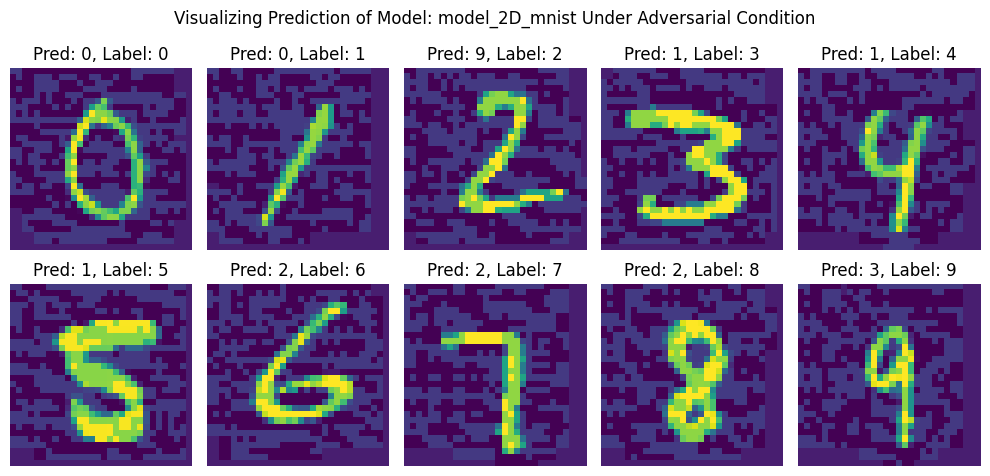

  9%|▉         | 1/11 [00:02<00:28,  2.86s/it]2022-12-05 00:49:51.131865: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 15.00MiB (rounded to 15728640)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-05 00:49:51.131934: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2022-12-05 00:49:51.131945: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 667, Chunks in use: 667. 166.8KiB allocated for chunks. 166.8KiB in use in bin. 88.7KiB client-requested in use in bin.
2022-12-05 00:49:51.131951: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 210, Chunks in use: 210. 106.2KiB allocated for chunks. 106.2KiB in use in bin. 102.2KiB client-requested in use in bin.
202

ResourceExhaustedError: Exception encountered when calling layer 'batch_normalization_86' (type BatchNormalization).

{{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

Call arguments received by layer 'batch_normalization_86' (type BatchNormalization):
  • inputs=tf.Tensor(shape=(30, 2048, 64), dtype=float32)
  • training=None

In [20]:
for model_name in tqdm(model_eval_dict.keys()):
    
    values = model_eval_dict[model_name]
    model = values['model']
    model_type = values['model_type']
    fusion_type = values['fusion_type']
    fusion_layer = values['fusion_layer']

    # Generate adversarial samples...
    x_avd_sign_dict[model_name] = create_adversarial_pattern(model, model_type)

    #evalaute models performance on adversarial samples..

    if model_type == '2D':
        epsilons_2d = epsilons
        epsilons_3d = [0.0]
    elif model_type == '3D':
        epsilons_2d = [0.0]
        epsilons_3d = epsilons
    else:
        epsilons_2d = epsilons
        epsilons_3d = epsilons
    

    # Evaluate performance for different values of EPSILON
    for eps_2d in epsilons_2d:
        for eps_3d in epsilons_3d:
            
            x_del_dict = {}
            x_adv_dict = {}

            if model_type == '2D' or model_type == 'Fusion':
                # Noise to be added...
                x_del_dict['2D'] = x_avd_sign_dict[model_name]['2D'] * eps_2d
                x_adv_dict['2D'] = x_actual_dict['2D'] + x_del_dict['2D']
            
            if model_type == '3D' or model_type == 'Fusion':
                x_del_dict['3D'] = x_avd_sign_dict[model_name]['3D'] * eps_3d
                x_adv_dict['3D'] = x_actual_dict['3D'] + x_del_dict['3D']

            if model_type == 'Fusion':
                x_adv_dict['Fusion'] = [x_adv_dict['2D'], x_adv_dict['3D']]
            

            # Evaluate model on adversarial data...
            accuracy_adv = model.evaluate(x_adv_dict[model_type], y_actual, batch_size=32, verbose = 0)[1]
            # print(f"Test Accuracy of {model_name}: {np.round(accuracy_adv*100,5)}%")

            y_adv_pred = model.predict(x_adv_dict[model_type], batch_size = 32, verbose = 0)

            # Classification matrix...
            y_adv_pred_digit = np.argmax(y_adv_pred, axis=1)
            # cls_rep_adv = classification_report(y_actual_digit, y_adv_pred_digit) 
            cls_rep_adv = None

            model_eval_adv.append([model_name, model_type, fusion_type, fusion_layer, eps_2d, eps_3d, accuracy_adv, cls_rep_adv])

    # Visualize adversarila samples..
    visualize_prediction(model_name, model_type, model, vis_type = 'Adversarial')          

In [ ]:
model_eval_adv_df = pd.DataFrame(model_eval_adv, columns = ['model_name', 'model_type', 'fusion_type', 'fusion_layer', 'eps_2d', 'eps_3d', 'accuracy_adv', 'cls_rep_adv'])
model_eval_adv_df

In [ ]:
model_eval_adv_df[model_eval_adv_df['model_type'] == '2D']
model_eval_adv_df[model_eval_adv_df['model_type'] == '3D']


In [ ]:
model_eval_adv_df.to_csv("generated_data/model_eval_adv.csv", header = True, index = True)

In [ ]:
model_eval_adv_df = pd.read_csv("generated_data/model_eval_adv.csv", index_col=0)
model_eval_adv_df

In [ ]:
# Adding None for the None valies..
model_eval_adv_df = model_eval_adv_df.fillna('None')

In [ ]:
model_eval_adv_df_cut = model_eval_adv_df[model_eval_adv_df['fusion_type'] == 'None']
model_eval_adv_df_cut['Epsilon'] = model_eval_adv_df_cut['eps_2d'] + model_eval_adv_df_cut['eps_3d'] 
sns.barplot(data = model_eval_adv_df_cut, x = 'Epsilon', y = 'accuracy_adv', hue = 'model_type')

In [ ]:
filer_1 = model_eval_adv_df['model_type'] == 'Fusion'
filer_2 = model_eval_adv_df['eps_3d'] == 0.0

model_eval_adv_df_cut = model_eval_adv_df.where(filer_1 & filer_2).dropna()
model_eval_adv_df_cut['Epsilon'] = model_eval_adv_df_cut['eps_2d'] + model_eval_adv_df_cut['eps_3d'] 
sns.barplot(data = model_eval_adv_df_cut, x = 'eps_2d', y = 'accuracy_adv', hue = 'fusion_type')

In [ ]:
filer_1 = model_eval_adv_df['model_type'] == 'Fusion'
filer_2 = model_eval_adv_df['eps_2d'] == 0.0

model_eval_adv_df_cut = model_eval_adv_df.where(filer_1 & filer_2).dropna()
model_eval_adv_df_cut['Epsilon'] = model_eval_adv_df_cut['eps_2d'] + model_eval_adv_df_cut['eps_3d'] 
sns.barplot(data = model_eval_adv_df_cut, x = 'eps_3d', y = 'accuracy_adv', hue = 'fusion_type')

In [ ]:
model_eval_adv_df_cut = model_eval_adv_df[model_eval_adv_df['model_type'] == 'Fusion']
model_eval_adv_df_cut['Epsilon'] = (model_eval_adv_df_cut['eps_2d'] + model_eval_adv_df_cut['eps_3d'])/2 
sns.barplot(data = model_eval_adv_df_cut, x = 'Epsilon', y = 'accuracy_adv', hue = 'fusion_type')

In [ ]:
filer_1 = model_eval_adv_df['fusion_type'] == 'Mid'

model_eval_adv_df_cut = model_eval_adv_df.where(filer_1).dropna()
model_eval_adv_df_cut['Epsilon'] = (model_eval_adv_df_cut['eps_2d'] + model_eval_adv_df_cut['eps_3d'])/2 
sns.lineplot(data = model_eval_adv_df_cut, x = 'Epsilon', y = 'accuracy_adv', hue = 'fusion_layer', markers= True, markersize = 10) # = 'p')
plt.legend(title = 'Epsilon', bbox_to_anchor = (1,1))
plt.show()

In [ ]:
filer_1 = model_eval_adv_df['fusion_type'] == 'Mid'
filer_2 = model_eval_adv_df['eps_2d'] == 0.0

model_eval_adv_df_cut = model_eval_adv_df.where(filer_1 & filer_2).dropna()
model_eval_adv_df_cut['Epsilon'] = (model_eval_adv_df_cut['eps_2d'] + model_eval_adv_df_cut['eps_3d'])/2 
sns.barplot(data = model_eval_adv_df_cut, hue = 'eps_3d', y = 'accuracy_adv', x = 'fusion_layer')
plt.legend(title = 'eps_3d', bbox_to_anchor = (1,1))
plt.show()

In [ ]:
filer_1 = model_eval_adv_df['fusion_type'] == 'Mid'
filer_2 = model_eval_adv_df['eps_3d'] == 0.0

model_eval_adv_df_cut = model_eval_adv_df.where(filer_1 & filer_2).dropna()
model_eval_adv_df_cut['Epsilon'] = (model_eval_adv_df_cut['eps_2d'] + model_eval_adv_df_cut['eps_3d'])/2 
sns.barplot(data = model_eval_adv_df_cut, hue = 'eps_2d', y = 'accuracy_adv', x = 'fusion_layer')
plt.legend(title = 'eps_2d', bbox_to_anchor = (1,1))
plt.show()